# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [1]:
from keras.datasets import mnist

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

Using TensorFlow backend.


In [2]:
X_raw.shape

(60000, 28, 28)

### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

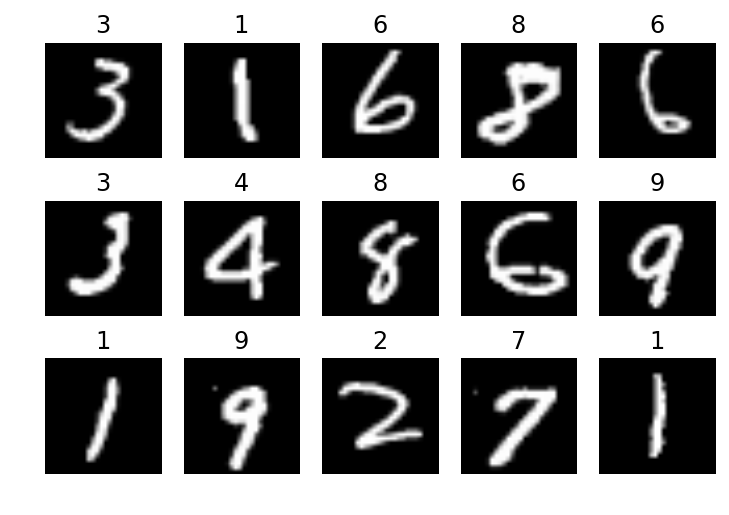

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。


In [4]:
import numpy as np

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # TODO: 随机取1~5个数字，并拼接成新的图片
    
    for index in range(X_len):
        num = random.randint(1, n_len)
        for i in range(num):
            rnd = random.randint(0, X_len-1)
            X_gen[index][0:height, width*i:width*(i+1)] = X[rnd].reshape(28,28,1)
            y_gen[i][index, y[rnd]] = 1
        for i in range(num, n_len):
            y_gen[i][index, 10] = 1
    return X_gen, y_gen

X_train, y_train = generate_dataset(X_raw, y_raw)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)

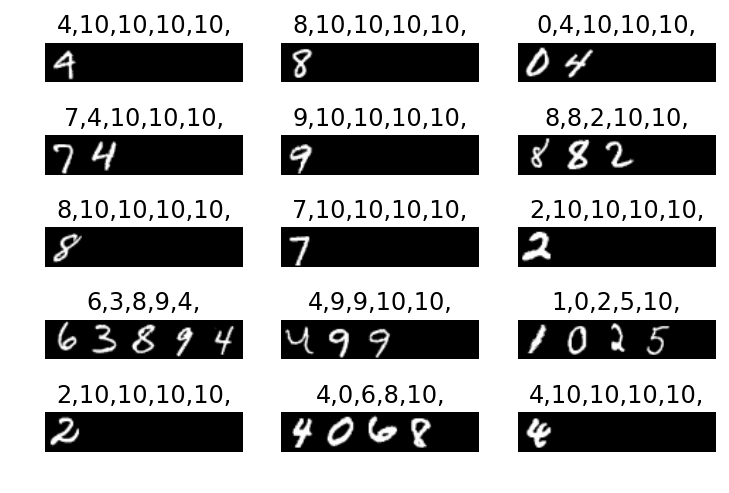

In [5]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

### 问题 1
_你是如何合成数据集的？_

**回答：**
1. 每一次生成，随机选择1-5张原样本。
2. 原样本数据横向拼接在生成的数据集上，使用np的多维索引赋值功能。
3. label数据，转换为one-hot编码。label数据数据有5个，表示第几个数据的label。
4. 第11个分类（数字10）表示空白

### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在每个分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，你可以使用 [泛型模型](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [6]:
from keras.models import Model
from keras.layers import *
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.layers.core import Reshape

#输出层
inputs = Input(shape=(height, width * n_len, 1), name='input')

#第一层3x3卷积和池化
x = Convolution2D(16, 3, 3, border_mode='valid', name='conv-1', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool-1')(x)

#第二层3x3卷积和池化
x = Convolution2D(16, 3, 3, border_mode='valid', name='conv-2', activation='relu')(x)
x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), border_mode='valid', name='pool-2')(x)

x = Flatten()(x)

#全连接层
x = Dense(100, activation='relu', name='dense')(x)

#5个softmax预测
predictions = []
for i in range(n_len):
    predictions.append(Dense(11, activation='softmax', name='digit_' + str(i))(x))

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 

首先分析数据的构建方式，5个数字是复制拼接的，每个数字的识别是和位置不相关，首先考虑是CNN。卷积神经网络是一种特殊的多层神经网络，像其它的神经网络一样，卷积神经网络也使用一种反向传播算法来进行训练，不同之处在于网络的结构。卷积神经网络的网络连接具有局部连接、参数共享的特点。局部连接是相对于普通神经网络的全连接而言的，是指这一层的某个节点只与上一层的部分节点相连。参数共享是指一层中多个节点的连接共享相同的一组参数。

### 可视化你的网络模型

参考链接：[visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是 PNG 格式，也可以是 SVG 格式。

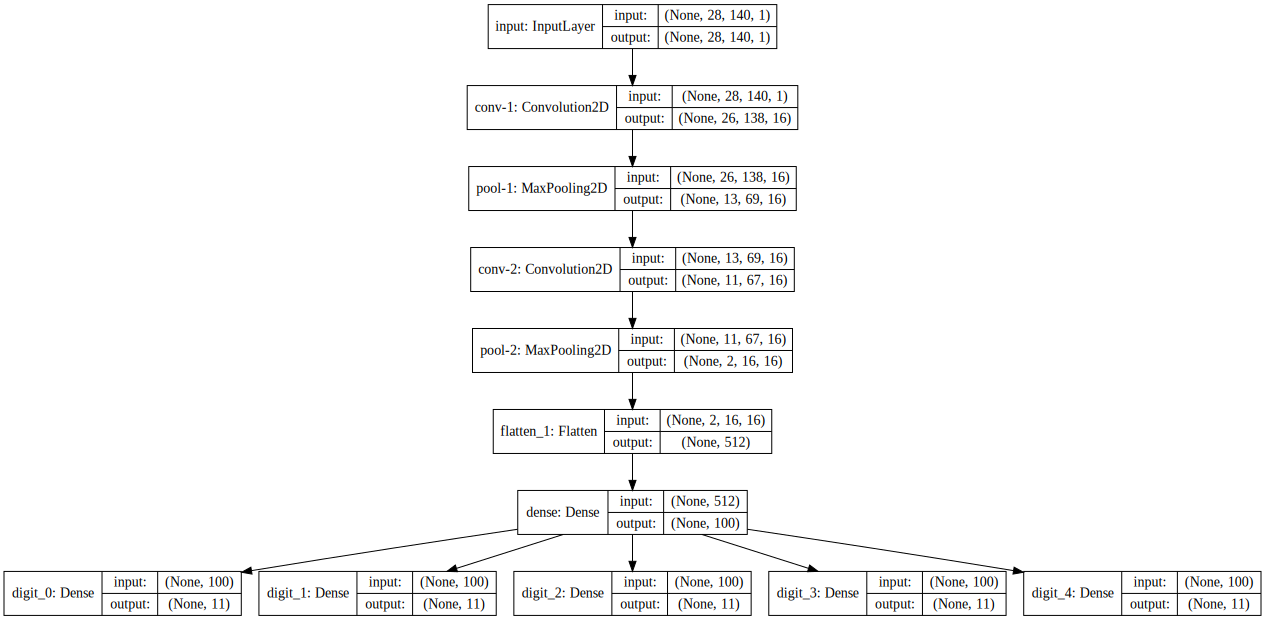

In [7]:
from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import Image, SVG

# TODO: 可视化你的模型
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**

1. 模型第一层是输入层。输入的28 x 140 x 1的图片数据。
2. 模型第二层是卷积层。这里设置16个卷积核，3 x 3的采样大小，valid padding。激活函数使用relu。
3. 模型第三层是池化层。设置了2 x 2的max pool。减少了参数的数量，防止过拟合现象的发生。
2. 模型第四层是第二个卷积层。这里设置16个卷积核，3 x 3的采样大小，valid padding。激活函数使用relu。
3. 模型第五层是第二个池化层。设置了4 x 4的max pool。
4. 然后添加Flatten，把数据转化为一维的数据。n x 512
5. 然后添加全联接层，大小100，激活函数使用relu。
6. 模型最后是全联接预测输出层，激活函数使用softmax。这里对5个数字分配设置了预测层。共享其他其他层的参数。

尝试了设置更大的卷积核数量，更大的全联接层，但是在我的电脑上已经很难训练了。后续考虑找一个GPU云主机试一下。

### 练习：训练你的网络模型

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

In [8]:
model.fit(X_train, {'digit_'+str(i): y_train[i] for i in range(n_len)}, 
          batch_size=128, nb_epoch=5, validation_split=0.2) 

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 100s - loss: 12.0126 - digit_0_loss: 2.7626 - digit_1_loss: 2.9645 - digit_2_loss: 2.2378 - digit_3_loss: 3.0702 - digit_4_loss: 0.9775 - digit_0_acc: 0.6030 - digit_1_acc: 0.6050 - digit_2_acc: 0.6814 - digit_3_acc: 0.6616 - digit_4_acc: 0.8447 - val_loss: 1.5049 - val_digit_0_loss: 0.3571 - val_digit_1_loss: 0.3334 - val_digit_2_loss: 0.2829 - val_digit_3_loss: 0.2484 - val_digit_4_loss: 0.2831 - val_digit_0_acc: 0.8887 - val_digit_1_acc: 0.8954 - val_digit_2_acc: 0.9102 - val_digit_3_acc: 0.9225 - val_digit_4_acc: 0.9196

**nb_epoch**设置的5。训练发现到第五批的时候，train loss继续降低，validation loss已经开始升高了。模型开始过拟合，提前结束。

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [9]:
predict_result = model.predict(X_test, batch_size=128)

In [11]:
def evaluate():
    # TODO: 按照错一个就算错的规则计算准确率
    predict = np.argmax(predict_result, axis=2)
    real = np.argmax(y_test, axis=2)
    compare = (predict == real).all(axis=0)
    return compare.sum()/float(len(compare))

print "Accuary is {:.2%}.".format(evaluate())

Accuary is 85.13%.


### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**

模型最终的准确率是85.13%。和前沿的模型精度比较还比较低。做实际数字识别，错误率偏高。能不能使用，取决于真实业务的需求。如果需要在更复杂的场景下使用，是需要更复杂网络结构，更多的数据。最重要的是需要更多的训练时间，最好有GPU加速训练。

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

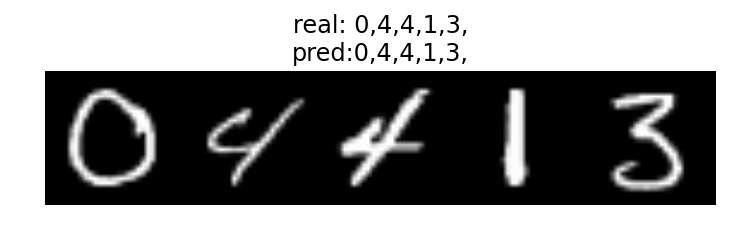

In [15]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
y_pred = model.predict(X_test[index].reshape(1, height, width*n_len, 1))

plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要将模型的权值和结构保存，以便下次调用。

In [13]:
model.save_weights('model.h5')
with open('model.json', 'w') as f:
    f.write(model.to_json())